In [7]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

print(sys.version_info)
for module in mpl, np, pd, sklearn, torch:
    print(module.__name__, module.__version__)
    
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)


sys.version_info(major=3, minor=10, micro=12, releaselevel='final', serial=0)
matplotlib 3.7.4
numpy 1.24.3
pandas 2.1.4
sklearn 1.2.2
torch 2.0.0
cuda:0


## 数据加载

- 采用WMT16的德语和英语平行语料库，数据集主页：[WMT16](https://www.statmt.org/wmt16/multimodal-task.html#task1)

In [8]:
# 这部分我们在本地完成
# !pip install sacremoses
# pip install subword-nmt
# # BPE分词
# !sh data_multi30k.sh wmt16 de en
!ls

Dataset

In [9]:
!ls ../input/wmt16-de-en

bpe.10000	  test_trg.bpe	    train_src.bpe      val.en		vocab
test.de		  test_trg.cut.txt  train_src.cut.txt  val_src.bpe
test.en		  train.de	    train_trg.bpe      val_src.cut.txt
test_src.bpe	  train.en	    train_trg.cut.txt  val_trg.bpe
test_src.cut.txt  train_l	    val.de	       val_trg.cut.txt


In [15]:
from pathlib import Path
from torch.utils.data import Dataset, DataLoader



class LangPairDataset(Dataset):

    def __init__(
        self, mode="train", max_length=128, overwrite_cache=False, data_dir="../input/wmt16-de-en",
    ):
        self.data_dir = Path(data_dir)
        cache_path = Path(".cache/" + f"de2en_{mode}_{max_length}.npy")

        if overwrite_cache or not cache_path.exists():
            cache_path.parent.mkdir(parents=True, exist_ok=True)

            with open(self.data_dir / f"{mode}_src.bpe", "r", encoding="utf8") as file:
                self.src = file.readlines()

            with open(self.data_dir / f"{mode}_trg.bpe", "r", encoding="utf8") as file:
                self.trg = file.readlines()

            filtered_src = []
            filtered_trg = []
            # max length filter
            for src, trg in zip(self.src, self.trg):
                if len(src) <= max_length and len(trg) <= max_length:
                    filtered_src.append(src.strip())
                    filtered_trg.append(trg.strip())

            np.save(
                cache_path,
                {"src": np.array(filtered_src), "trg": np.array(filtered_trg)},
                allow_pickle=True,
            )
            print(f"save cache to {cache_path}")

        else:
            cache_dict = np.load(cache_path, allow_pickle=True).item()
            print(f"load {mode} dataset from {cache_path}")
            filtered_src = cache_dict["src"]
            filtered_trg = cache_dict["trg"]

        self.src = filtered_src
        self.trg = filtered_trg

    def __getitem__(self, index):
        return self.src[index], self.trg[index]

    def __len__(self):
        return len(self.src)
        

train_ds = LangPairDataset("train")
val_ds = LangPairDataset("val")

save cache to .cache/de2en_train_128.npy
save cache to .cache/de2en_val_128.npy


In [16]:
print("source: {}\ntarget: {}".format(*train_ds[-1]))

source: ein älterer mann sitzt mit einem jungen mit einem wagen vor einer fassade .
target: an elderly man sits outside a storefront accompani@@ ed by a young boy with a cart .


### Tokenizer

这里有两种处理方式，分别对应着 encoder 和 decoder 的 word embedding 是否共享，这里实现共享的方案

In [18]:
#载入词表，看下词表长度，词表就像英语字典
word2idx = {
    "[PAD]": 0,     # 填充 token
    "[BOS]": 1,     # begin of sentence
    "[UNK]": 2,     # 未知 token
    "[EOS]": 3,     # end of sentence
}
idx2word = {value: key for key, value in word2idx.items()}
index = len(idx2word)
threshold = 1  # 出现次数低于此的token舍弃

with open("../input/wmt16-de-en/vocab", "r", encoding="utf8") as file:
    for line in tqdm(file.readlines()):
        token, counts = line.strip().split()
        if int(counts) >= threshold:
            word2idx[token] = index
            idx2word[index] = token
            index += 1
            
vocab_size = len(word2idx)
print("vocab_size: {}".format(vocab_size))

  0%|          | 0/9714 [00:00<?, ?it/s]

vocab_size: 9718


In [19]:
class Tokenizer:
    def __init__(self, word2idx, idx2word, max_length=128, pad_idx=0, bos_idx=1, eos_idx=3, unk_idx=2):
        self.word2idx = word2idx
        self.idx2word = idx2word
        self.max_length = max_length
        self.pad_idx = pad_idx
        self.bos_idx = bos_idx
        self.eos_idx = eos_idx
        self.unk_idx = unk_idx
    
    def encode(self, text_list, padding_first=False, add_bos=True, add_eos=True, return_mask=False):
        """如果padding_first == True，则padding加载前面，否则加载后面"""
        max_length = min(self.max_length, add_eos + add_bos + max([len(text) for text in text_list]))
        indices_list = []
        for text in text_list:
            indices = [self.word2idx.get(word, self.unk_idx) for word in text[:max_length - add_bos - add_eos]]
            if add_bos:
                indices = [self.bos_idx] + indices
            if add_eos:
                indices = indices + [self.eos_idx]
            if padding_first:
                indices = [self.pad_idx] * (max_length - len(indices)) + indices
            else:
                indices = indices + [self.pad_idx] * (max_length - len(indices))
            indices_list.append(indices)
        input_ids = torch.tensor(indices_list)
        masks = (input_ids == self.pad_idx).to(dtype=torch.int64)
        return input_ids if not return_mask else (input_ids, masks)
    
    
    def decode(self, indices_list, remove_bos=True, remove_eos=True, remove_pad=True, split=False):
        text_list = []
        for indices in indices_list:
            text = []
            for index in indices:
                word = self.idx2word.get(index, "[UNK]")
                if remove_bos and word == "[BOS]":
                    continue
                if remove_eos and word == "[EOS]":
                    break
                if remove_pad and word == "[PAD]":
                    break
                text.append(word)
            text_list.append(" ".join(text) if not split else text)
        return text_list
    

tokenizer = Tokenizer(word2idx=word2idx, idx2word=idx2word)

tokenizer.encode([["hello"], ["hello", "world"]], add_bos=True, add_eos=False)
raw_text = ["hello world".split(), "tokenize text datas with batch".split(), "this is a test".split()]
indices = tokenizer.encode(raw_text, padding_first=False, add_bos=False, add_eos=True)
decode_text = tokenizer.decode(indices.tolist(), remove_bos=False, remove_eos=False, remove_pad=False)
print("raw text")
for raw in raw_text:
    print(raw)
print("indices")
for index in indices:
    print(index)
print("decode text")
for decode in decode_text:
    print(decode)

raw text
['hello', 'world']
['tokenize', 'text', 'datas', 'with', 'batch']
['this', 'is', 'a', 'test']
indices
tensor([   2, 4517,    3,    0,    0,    0])
tensor([   2, 7167,    2,   22,    2,    3])
tensor([ 425,   18,    5, 4493,    3,    0])
decode text
[UNK] world [EOS] [PAD] [PAD] [PAD]
[UNK] text [UNK] with [UNK] [EOS]
this is a test [EOS] [PAD]


### Transformer Batch Sampler

> Sentence pairs were batched together by approximate sequence length. Each training batch contained a set of sentence pairs containing approximately 25000 source tokens and 25000 target tokens

In [20]:
class SampleInfo:
    def __init__(self, i, lens):
        """
        记录文本对的序号和长度信息
        输入：
            - i (int): 文本对的序号。
            - lens (list): 文本对源语言和目标语言的长度
        """
        self.i = i
        # 加一是考虑填补在文本前后的特殊词元
        self.max_len = max(lens[0], lens[1]) + 1
        self.src_len = lens[0] + 1
        self.trg_len = lens[1] + 1


class TokenBatchCreator:
    def __init__(self, batch_size):
        """
        按照词元数目限制的批量生成器
        输入：
            - batch_size (int): 批量大小限制
        """

        self._batch = []
        self.max_len = -1
        self._batch_size = batch_size

    def append(self, info):
        """
        输入：
            - info (SampleInfo): 文本对的信息
        """
        # 更新当前批量的最大长度
        cur_len = info.max_len
        max_len = max(self.max_len, cur_len)
        # 如果新的样本加入批量后超过大小限制，则将已有的批量返回，新的样本加入新的批量
        if max_len * (len(self._batch) + 1) > self._batch_size:
            self._batch, result = [], self._batch
            self._batch.append(info)
            self.max_len = cur_len
            return result
        else:
            self.max_len = max_len
            self._batch.append(info)

    @property
    def batch(self):
        return self._batch

In [21]:
from torch.utils.data import BatchSampler
import numpy as np


class TransformerBatchSampler(BatchSampler):
    def __init__(self,
                 dataset,
                 batch_size,
                 shuffle_batch=False,
                 clip_last_batch=False,
                 seed=0):
        """
        批量采样器
        输入:
            - dataset: 数据集
            - batch_size: 批量大小
            - shuffle_batch: 是否对打乱生成的批量
            - clip_last_batch: 是否裁剪最后剩下的数据
            - seed: 随机数种子
        """
        self._dataset = dataset
        self._batch_size = batch_size
        self._shuffle_batch = shuffle_batch
        self._clip_last_batch = clip_last_batch
        self._seed = seed
        self._random = np.random
        self._random.seed(seed)

        self._sample_infos = []
        for i, data in enumerate(self._dataset):
            lens = [len(data[0]), len(data[1])]
            self._sample_infos.append(SampleInfo(i, lens))

    def __iter__(self):
        """
        迭代采样。在这里TransformerBatchSampler将生成每一个批量数据在原数据集的序号，并在迭代中不断抛出。
        """
        # 排序，如果源语言长度相同则按照目标语言的长度排列
        infos = sorted(self._sample_infos,
                       key=lambda x: (x.src_len, x.trg_len))
        # 组装批量
        batch_infos = []
        batch_creator = TokenBatchCreator(self._batch_size)
        for info in infos:
            batch = batch_creator.append(info)
            # 存够一个batch的样本信息后，会把这个batch返回，否则返回为None
            if batch is not None:
                batch_infos.append(batch)

        # 是否抛弃最后批量的文本对
        if not self._clip_last_batch and len(batch_creator.batch) != 0:
            batch_infos.append(batch_creator.batch)

        # 打乱批量
        if self._shuffle_batch:
            self._random.shuffle(batch_infos)

        self.batch_number = len(batch_infos)

        # 抛出一个批量的文本对在数据集中的序号
        for batch in batch_infos:
            batch_indices = [info.i for info in batch]
            yield batch_indices

    def __len__(self):
        """
        返回批量的数量
        """
        if hasattr(self, "batch_number"):
            return self.batch_number
        # 计算批量的数量
        batch_number = (len(self._dataset) +
                        self._batch_size) // self._batch_size
        return batch_number

In [22]:
sampler = TransformerBatchSampler(train_ds, batch_size=4096, shuffle_batch=True)
for idx, batch in enumerate(sampler):
    print("第{}批量的数据中含有文本对的数目为：{}".format(idx, len(batch)))
    if idx >= 2:
        break

第0批量的数据中含有文本对的数目为：83
第1批量的数据中含有文本对的数目为：49
第2批量的数据中含有文本对的数目为：35


### DataLoader

In [23]:
def collate_fct(batch, tokenizer):
    src_words = [pair[0].split() for pair in batch]
    trg_words = [pair[1].split() for pair in batch]
    
    # [BOS] src [EOS] [PAD]
    encoder_inputs, encoder_inputs_mask = tokenizer.encode(
        src_words, padding_first=False, add_bos=True, add_eos=True, return_mask=True
        )
    
    # [BOS] trg [PAD]
    decoder_inputs = tokenizer.encode(
        trg_words, padding_first=False, add_bos=True, add_eos=False, return_mask=False,
        )
    
    # trg [EOS] [PAD]
    decoder_labels, decoder_labels_mask = tokenizer.encode(
        trg_words, padding_first=False, add_bos=False, add_eos=True, return_mask=True
        )

    return {
        "encoder_inputs": encoder_inputs.to(device=device),
        "encoder_inputs_mask": encoder_inputs_mask.to(device=device),
        "decoder_inputs": decoder_inputs.to(device=device),
        "decoder_labels": decoder_labels.to(device=device),
        "decoder_labels_mask": decoder_labels_mask.to(device=device),
    }
    

In [24]:
from functools import partial


sampler = TransformerBatchSampler(train_ds, batch_size=256, shuffle_batch=True)
sample_dl = DataLoader(train_ds, batch_sampler=sampler, collate_fn=partial(collate_fct, tokenizer=tokenizer))

for batch in sample_dl:
    for key, value in batch.items():
        print(key)
        print(value)
    break

encoder_inputs
tensor([[   1,    7,   17,    6,    8,   89,  157,   73,    7,  541,  255,    9,
           14,   42,  153,  119, 1481,  406, 2384, 1319,    4,    3],
        [   1,  521,    6,    8,  808, 1299, 2305, 1638, 2535,  184,   31, 1735,
          961,   55, 1732,    4,    3,    0,    0,    0,    0,    0]],
       device='cuda:0')
encoder_inputs_mask
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]],
       device='cuda:0')
decoder_inputs
tensor([[   1,    5,   16,    6,    5,   50,   41,   18,   78,    5,  421,  254,
         7050,  106,  471,    4],
        [   1,  452,    6,    5, 5010, 1118, 1010,  106,    5,  517, 5103,    4,
            0,    0,    0,    0]], device='cuda:0')
decoder_labels
tensor([[   5,   16,    6,    5,   50,   41,   18,   78,    5,  421,  254, 7050,
          106,  471,    4,    3],
        [ 452,    6,    5, 5010, 1118, 1010,  106,    5,  517, 5103,

## 定义模型

- Transformer模型由Embedding、Transformer-Block组成
- Embedding包括：
    - WordEmbedding
    - PositionEmbedding
- Transformer-Block包括：
    - Self-Attention
    - Cross-Attention
    - MLP

### Embedding

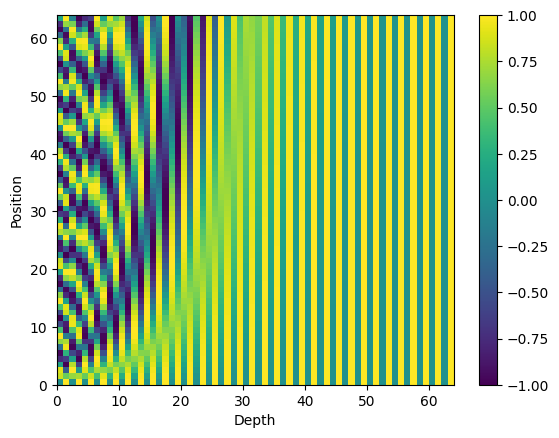

In [25]:

class TransformerEmbedding(nn.Module):
    def __init__(self, config):
        super().__init__()
        # hyper params
        self.vocab_size = config["vocab_size"]
        self.hidden_size = config["d_model"]
        self.pad_idx = config["pad_idx"]
        dropout_rate = config["dropout"]
        self.max_length = config["max_length"]

        # layers
        self.word_embedding = nn.Embedding(
            self.vocab_size, self.hidden_size, padding_idx=self.pad_idx
        )
        self.pos_embedding = nn.Embedding(
            self.max_length,
            self.hidden_size,
            _weight=self.get_positional_encoding(
                self.max_length, self.hidden_size
            ),
        )
        self.pos_embedding.weight.requires_grad_(False)
        self.dropout = nn.Dropout(dropout_rate)

    def get_word_embedding_weights(self):
        return self.word_embedding.weight

    # 计算位置信息
    @classmethod
    def get_positional_encoding(self, max_length, hidden_size):
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_length, hidden_size)
        position = torch.arange(0, max_length).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, hidden_size, 2)
            * -(torch.log(torch.Tensor([10000.0])) / hidden_size)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        return pe

    def forward(self, input_ids):
        # input_ids: [batch_size, seq_len]
        seq_len = input_ids.shape[1]
        assert (
            seq_len <= self.max_length
        ), f"input sequence length should no more than {self.max_length} but got {seq_len}"

        position_ids = torch.arange(seq_len, dtype=torch.long, device=input_ids.device)
        position_ids = position_ids.unsqueeze(0).expand_as(input_ids)

        # embedding
        word_embeds = self.word_embedding(input_ids)
        pos_embeds = self.pos_embedding(position_ids)
        embeds = word_embeds + pos_embeds
        embeds = self.dropout(embeds)

        return embeds


def plot_position_embedding(position_embedding):
    plt.pcolormesh(position_embedding)
    plt.xlabel('Depth')
    plt.ylabel('Position')
    plt.colorbar()
    plt.show()

position_embedding = TransformerEmbedding.get_positional_encoding(64, 64)
plot_position_embedding(position_embedding)


### Transformer Block

#### scaled-dot-product-attention

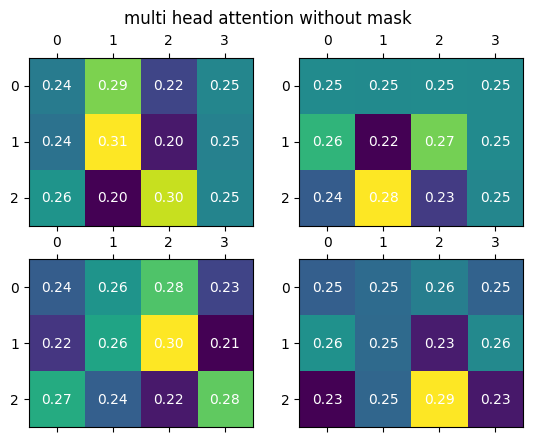

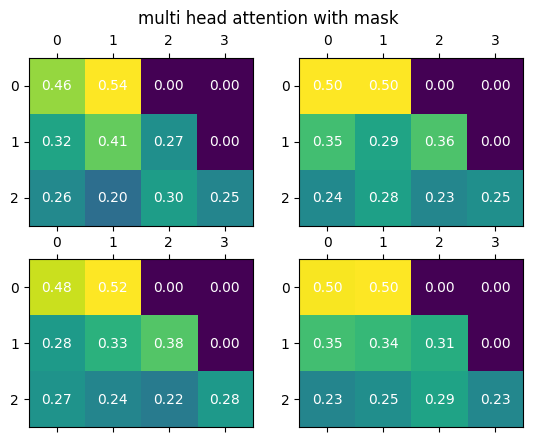

In [26]:
from dataclasses import dataclass
from typing import Optional, Tuple

Tensor = torch.Tensor

@dataclass
class AttentionOutput:
    hidden_states: Tensor
    attn_scores: Tensor

class MultiHeadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        # hyper params
        self.hidden_size = config["d_model"]
        self.num_heads = config["num_heads"]
        assert (
            self.hidden_size % self.num_heads == 0
        ), "Hidden size must be divisible by num_heads but got {} and {}".format(
            self.hidden_size, self.num_heads
        )
        self.head_dim = self.hidden_size // self.num_heads

        # layers
        self.Wq = nn.Linear(self.hidden_size, self.hidden_size, bias=False)
        self.Wk = nn.Linear(self.hidden_size, self.hidden_size, bias=False)
        self.Wv = nn.Linear(self.hidden_size, self.hidden_size, bias=False)
        self.Wo = nn.Linear(self.hidden_size, self.hidden_size, bias=False)

    def _split_heads(self, x: Tensor) -> Tensor:
        bs, seq_len, _ = x.shape
        x = x.view(bs, seq_len, self.num_heads, self.head_dim)
        return x.permute(0, 2, 1, 3)

    def _merge_heads(self, x: Tensor) -> Tensor:
        bs, _, seq_len, _ = x.shape
        return x.permute(0, 2, 1, 3).reshape(bs, seq_len, self.hidden_size)

    def forward(self, querys, keys, values, attn_mask=None) -> AttentionOutput:
        # split heads
        querys = self._split_heads(self.Wq(querys))
        keys = self._split_heads(self.Wk(keys))
        values = self._split_heads(self.Wv(values))

        # calculate attention scores
        qk_logits = torch.matmul(querys, keys.mT)
        if attn_mask is not None:
            attn_mask = attn_mask[:, :, : querys.shape[-2], : keys.shape[-2]]
            qk_logits += attn_mask * -1e9
        attn_scores = F.softmax(qk_logits / (self.head_dim**0.5), dim=-1)

        # apply attention scores
        embeds = torch.matmul(attn_scores, values)
        embeds = self.Wo(self._merge_heads(embeds))

        return AttentionOutput(hidden_states=embeds, attn_scores=attn_scores)
        
mha = MultiHeadAttention({"num_heads": 2, "d_model": 2})
query = torch.randn(2, 3, 2)
query /= query.norm(dim=-1, keepdim=True)
key_value = torch.cat([query[:, :2], torch.randn(2, 2, 2)], dim=1)

outputs = mha(query, key_value, key_value)

fig, axis = plt.subplots(*outputs.attn_scores.shape[:2])
for i in range(query.shape[0]):
    for j in range(outputs.attn_scores.shape[1]):
        axis[i, j].matshow(outputs.attn_scores[i, j].detach().numpy())
        for x in range(outputs.attn_scores.shape[2]):
            for y in range(outputs.attn_scores.shape[3]):
                axis[i, j].text(y, x, f"{outputs.attn_scores[i, j, x, y]:.2f}", ha="center", va="center", color="w")
fig.suptitle("multi head attention without mask")
plt.show()

# mask
mask = torch.Tensor([[0, 0, 1, 1], [0, 0, 0, 1], [0, 0, 0, 0]]).reshape(1, 1, 3, 4)
outputs_masked = mha(query, key_value, key_value, mask)

fig, axis = plt.subplots(*outputs_masked.attn_scores.shape[:2])
for i in range(query.shape[0]):
    for j in range(outputs_masked.attn_scores.shape[1]):
        axis[i, j].matshow(outputs_masked.attn_scores[i, j].detach().numpy())
        for x in range(outputs_masked.attn_scores.shape[2]):
            for y in range(outputs_masked.attn_scores.shape[3]):
                axis[i, j].text(y, x, f"{outputs_masked.attn_scores[i, j, x, y]:.2f}", ha="center", va="center", color="w")
fig.suptitle("multi head attention with mask")
plt.show()

#### Transformer-Block

In [27]:

@dataclass
class TransformerBlockOutput:
    hidden_states: Tensor
    self_attn_scores: Tensor
    cross_attn_scores: Optional[Tensor] = None

class TransformerBlock(nn.Module):
    def __init__(self, config, add_cross_attention=False):
        super().__init__()
        # hyper params
        self.hidden_size = config["d_model"]
        self.num_heads = config["num_heads"]
        dropout_rate = config["dropout"]
        ffn_dim = config["dim_feedforward"]
        eps = config["layer_norm_eps"]

        # self-attention
        self.self_atten = MultiHeadAttention(config)
        self.self_ln = nn.LayerNorm(self.hidden_size, eps=eps)
        self.self_dropout = nn.Dropout(dropout_rate)

        # cross-attention
        if add_cross_attention:
            self.cross_atten = MultiHeadAttention(config)
            self.cross_ln = nn.LayerNorm(self.hidden_size, eps=eps)
            self.cross_dropout = nn.Dropout(dropout_rate)
        else:
            self.cross_atten = None

        # FFN
        self.ffn = nn.Sequential(
            nn.Linear(self.hidden_size, ffn_dim),
            nn.ReLU(),
            nn.Linear(ffn_dim, self.hidden_size),
        )
        self.ffn_ln = nn.LayerNorm(self.hidden_size, eps=eps)
        self.ffn_dropout = nn.Dropout(dropout_rate)

    def forward(
        self,
        hidden_states,
        attn_mask=None,
        encoder_outputs=None,
        cross_attn_mask=None,
    ):
        # self-attention
        self_atten_output = self.self_atten(
            hidden_states, hidden_states, hidden_states, attn_mask
        )
        self_embeds = self.self_ln(
            hidden_states + self.self_dropout(self_atten_output.hidden_states)
        )

        # cross-attention
        if self.cross_atten is not None:
            assert encoder_outputs is not None
            cross_atten_output = self.cross_atten(
                self_embeds, encoder_outputs, encoder_outputs, cross_attn_mask
            )
            cross_embeds = self.cross_ln(
                self_embeds + self.cross_dropout(cross_atten_output.hidden_states)
            )

        # FFN
        embeds = cross_embeds if self.cross_atten is not None else self_embeds
        ffn_output = self.ffn(embeds)
        embeds = self.ffn_ln(embeds + self.ffn_dropout(ffn_output))

        return TransformerBlockOutput(
            hidden_states=embeds,
            self_attn_scores=self_atten_output.attn_scores,
            cross_attn_scores=cross_atten_output.attn_scores
            if self.cross_atten is not None
            else None,
        )

#### Encoder

In [28]:
from typing import List

@dataclass
class TransformerEncoderOutput:
    last_hidden_states: Tensor
    attn_scores: List[Tensor]

class TransformerEncoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        # hyper params
        self.num_layers = config["num_encoder_layers"]

        # layers
        self.layers = nn.ModuleList(
            [TransformerBlock(config) for _ in range(self.num_layers)]
        )

    def forward(
        self, encoder_inputs_embeds, attn_mask=None
    ) -> TransformerEncoderOutput:
        attn_scores = []
        embeds = encoder_inputs_embeds
        for layer in self.layers:
            block_outputs = layer(embeds, attn_mask=attn_mask)
            embeds = block_outputs.hidden_states
            attn_scores.append(block_outputs.self_attn_scores)

        return TransformerEncoderOutput(
            last_hidden_states=embeds, attn_scores=attn_scores
        )



#### Decoder

In [29]:
@dataclass
class TransformerDecoderOutput:
    last_hidden_states: Tensor
    self_attn_scores: List[Tensor]
    cross_attn_scores: List[Tensor]


class TransformerDecoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        # hyper params
        self.num_layers = config["num_decoder_layers"]

        # layers
        self.layers = nn.ModuleList(
            [
                TransformerBlock(config, add_cross_attention=True)
                for _ in range(self.num_layers)
            ]
        )

    def forward(
        self,
        decoder_inputs_embeds,
        encoder_outputs,
        attn_mask=None,
        cross_attn_mask=None,
    ) -> TransformerDecoderOutput:
        self_attn_scores = []
        cross_attn_scores = []
        embeds = decoder_inputs_embeds
        for layer in self.layers:
            block_outputs = layer(
                embeds,
                attn_mask=attn_mask,
                encoder_outputs=encoder_outputs,
                cross_attn_mask=cross_attn_mask,
            )
            embeds = block_outputs.hidden_states
            self_attn_scores.append(block_outputs.self_attn_scores)
            cross_attn_scores.append(block_outputs.cross_attn_scores)

        return TransformerDecoderOutput(
            last_hidden_states=embeds,
            self_attn_scores=self_attn_scores,
            cross_attn_scores=cross_attn_scores,
        )


#### mask

- mask实际上只有两种
    1. `padding_mask`：mask掉`pad_idx`，不计算损失
    2. `attention_mask`：mask掉`pad_idx`，不计算注意力分数
- Decoder的`attention_mask`和Encoder有一定的区别：
    - Encoder可以同时看见序列所有信息，故只mask掉`pad_idx`
    - Decoder只能看到在自身之前的序列的信息，故要额外mask掉自身之后的序列

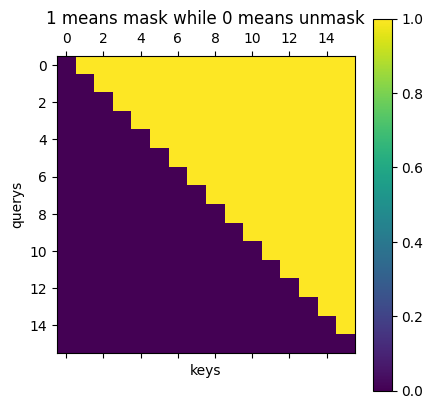

In [30]:
def generate_square_subsequent_mask(sz: int) -> Tensor:
    """
    Generate a square mask for the sequence. The masked positions are filled with True.
        Unmasked positions are filled with False.
    """
    mask = (torch.triu(torch.ones(sz, sz)) == 0).transpose(-1, -2).bool()

    return mask


plt.matshow(generate_square_subsequent_mask(16))
plt.colorbar()
plt.xlabel("keys")
plt.ylabel("querys")
plt.title("1 means mask while 0 means unmask")
plt.show()

['[BOS]', '[UNK]', '[UNK]', 'brown', '[UNK]', 'jumps', 'over', 'the', '[UNK]', 'dog', '.', '[EOS]']


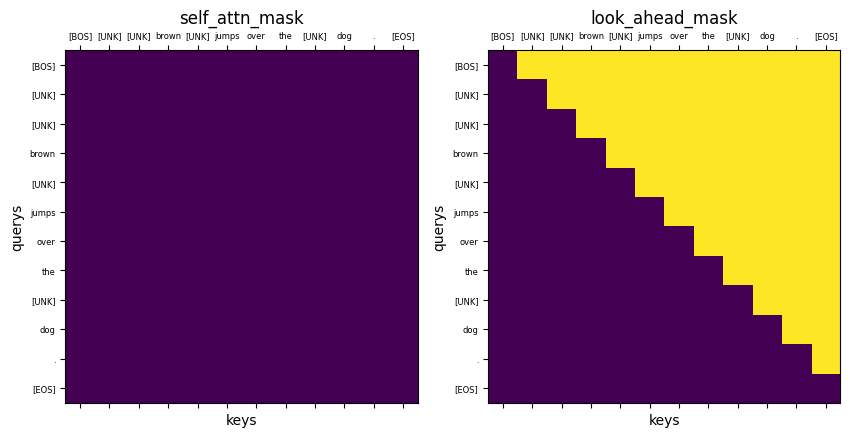

['[BOS]', '[UNK]', 'does', 'the', '[UNK]', 'say', '?', '[EOS]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


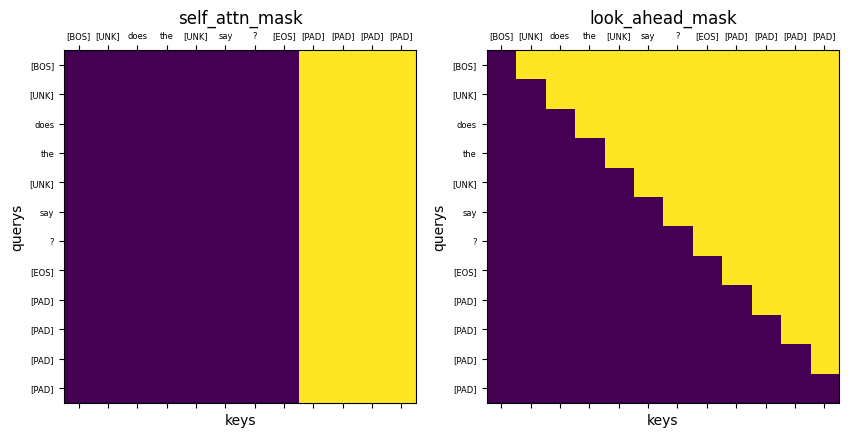

In [31]:
inputs_words = ["The quick brown fox jumps over the lazy dog .", "What does the fox say ?"]

inputs_ids, input_mask = tokenizer.encode([w.split() for w in inputs_words], return_mask=True)
for i in range(len(inputs_words)):
    decode_text = tokenizer.decode(inputs_ids[i: i+1].tolist(), remove_bos=False, remove_eos=False, remove_pad=False, split=True)[0]
    print(decode_text)
    self_attn_mask  = input_mask[i].reshape(1, -1).repeat_interleave(inputs_ids.shape[-1], dim=0)
    look_ahead_mask = generate_square_subsequent_mask(inputs_ids.shape[-1])

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].matshow(self_attn_mask)
    axs[0].set_title("self_attn_mask")
    axs[0].set_yticks(range(len(decode_text)), decode_text, fontsize=6)
    axs[0].set_ylabel("querys")
    axs[0].set_xticks(range(len(decode_text)), decode_text, fontsize=6)
    axs[0].set_xlabel("keys")
    axs[1].matshow(look_ahead_mask)
    axs[1].set_title("look_ahead_mask")
    axs[1].set_yticks(range(len(decode_text)), decode_text, fontsize=6)
    axs[1].set_ylabel("querys")
    axs[1].set_xticks(range(len(decode_text)), decode_text, fontsize=6)
    axs[1].set_xlabel("keys")
    plt.show()


#### Transformer Model

In [32]:
@dataclass
class TransformerOutput:
    logits: Tensor
    encoder_last_hidden_states: Tensor
    encoder_attn_scores: List[Tensor]
    decoder_last_hidden_states: Tensor
    decoder_self_attn_scores: List[Tensor]
    decoder_cross_attn_scores: List[Tensor]
    preds: Optional[Tensor] = None

class TransformerModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        # hyper params
        self.hidden_size = config["d_model"]
        self.num_encoder_layers = config["num_encoder_layers"]
        self.num_decoder_layers = config["num_decoder_layers"]
        self.pad_idx = config["pad_idx"]
        self.bos_idx = config["bos_idx"]
        self.eos_idx = config["eos_idx"]
        self.vocab_size = config["vocab_size"]
        self.dropout_rate = config["dropout"]
        self.max_length = config["max_length"]
        self.share = config["share_embedding"]

        # layers
        self.src_embedding = TransformerEmbedding(config)
        if self.share:
            self.trg_embedding = self.src_embedding
            self.linear = lambda x: torch.matmul(
                x, self.trg_embedding.get_word_embedding_weights().T
            )
        else:
            self.trg_embedding = TransformerEmbedding(config)
            self.linear = nn.Linear(self.hidden_size, self.vocab_size)

        self.encoder = TransformerEncoder(config)
        self.decoder = TransformerDecoder(config)

        # init weights
        self._init_weights()

    def _init_weights(self):
        """使用 xavier 均匀分布来初始化权重"""
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def generate_square_subsequent_mask(self, sz: int) -> Tensor:
        """
        Generate a square mask for the sequence. The masked positions are filled with True.
            Unmasked positions are filled with False.
        """
        mask = (torch.triu(torch.ones(sz, sz)) == 0).transpose(-1, -2).bool()

        return mask

    def forward(
        self, encoder_inputs, decoder_inputs, encoder_inputs_mask=None
    ) -> TransformerOutput:
        # encoder_inputs: [batch_size, src_len]
        # decoder_inputs: [batch_size, trg_len]
        # encoder_inputs_mask: [batch_size, src_len]
        if encoder_inputs_mask is None:
            encoder_inputs_mask = encoder_inputs.eq(self.pad_idx)
        encoder_inputs_mask = encoder_inputs_mask.unsqueeze(1).unsqueeze(
            2
        )  # [batch_size, 1, 1, src_len]
        look_ahead_mask = self.generate_square_subsequent_mask(decoder_inputs.shape[1])
        look_ahead_mask = (
            look_ahead_mask.unsqueeze(0).unsqueeze(0).to(decoder_inputs.device)
        )  # [1, 1, trg_len, trg_len]

        # encoding
        encoder_inputs_embeds = self.src_embedding(encoder_inputs)
        encoder_outputs = self.encoder(encoder_inputs_embeds, encoder_inputs_mask)

        # decoding
        decoder_inputs_embeds = self.trg_embedding(decoder_inputs)
        decoder_outputs = self.decoder(
            decoder_inputs_embeds=decoder_inputs_embeds,
            encoder_outputs=encoder_outputs.last_hidden_states,
            attn_mask=look_ahead_mask,
            cross_attn_mask=encoder_inputs_mask,
        )

        logits = self.linear(decoder_outputs.last_hidden_states)

        return TransformerOutput(
            logits=logits,
            encoder_last_hidden_states=encoder_outputs.last_hidden_states,
            encoder_attn_scores=encoder_outputs.attn_scores,
            decoder_last_hidden_states=decoder_outputs.last_hidden_states,
            decoder_self_attn_scores=decoder_outputs.self_attn_scores,
            decoder_cross_attn_scores=decoder_outputs.cross_attn_scores,
        )

    @torch.no_grad()
    def infer(self, encoder_inputs, encoder_inputs_mask=None) -> Tensor:
        # assert len(encoder_inputs.shape) == 2 and encoder_inputs.shape[0] == 1
        if encoder_inputs_mask is None:
            encoder_inputs_mask = encoder_inputs.eq(self.pad_idx)
        # 预测阶段，你通常只会逐步生成输出，而不需要像训练时那样批量地计算注意力。输入的是多长就是多长，不需要padding
        encoder_inputs_mask = encoder_inputs_mask.unsqueeze(1).unsqueeze(
            2
        )  # [batch_size, 1, 1, src_len]
        look_ahead_mask = self.generate_square_subsequent_mask(self.max_length)
        look_ahead_mask = (
            look_ahead_mask.unsqueeze(0).unsqueeze(0).to(encoder_inputs.device)
        )  # [1, 1, trg_len, trg_len]

        # encoding
        encoder_inputs_embeds = self.src_embedding(encoder_inputs)
        encoder_outputs = self.encoder(encoder_inputs_embeds)

        # decoding
        #预测时的look_ahead_mask可有可无，我们这里加不加都行
        decoder_inputs = torch.Tensor([self.bos_idx] * encoder_inputs.shape[0]).reshape(-1, 1).long().to(device=encoder_inputs.device)
        for cur_len in tqdm(range(1, self.max_length + 1)):
            decoder_inputs_embeds = self.trg_embedding(decoder_inputs)
            decoder_outputs = self.decoder(
                decoder_inputs_embeds=decoder_inputs_embeds,
                encoder_outputs=encoder_outputs.last_hidden_states,
                attn_mask=look_ahead_mask[:, :, :cur_len, :cur_len],
            )

            logits = self.linear(decoder_outputs.last_hidden_states)
            next_token = logits.argmax(dim=-1)[:, -1:]
            decoder_inputs = torch.cat([decoder_inputs, next_token], dim=-1)

            if all((decoder_inputs == self.eos_idx).sum(dim=-1) > 0):
                break

        return TransformerOutput(
            preds=decoder_inputs[:, 1:],
            logits=logits,
            encoder_last_hidden_states=encoder_outputs.last_hidden_states,
            encoder_attn_scores=encoder_outputs.attn_scores,
            decoder_last_hidden_states=decoder_outputs.last_hidden_states,
            decoder_self_attn_scores=decoder_outputs.self_attn_scores,
            decoder_cross_attn_scores=decoder_outputs.cross_attn_scores,
        )

## 训练

### 损失函数

In [33]:
class CrossEntropyWithPadding:
    def __init__(self, config):
        self.label_smoothing = config["label_smoothing"]
        
    def __call__(self, logits, labels, padding_mask=None):
        # logits.shape = [batch size, sequence length, num of classes]
        # labels.shape = [batch size, sequence length]
        # padding_mask.shape = [batch size, sequence length]
        bs, seq_len, nc = logits.shape
        loss = F.cross_entropy(logits.reshape(bs * seq_len, nc), labels.reshape(-1), reduce=False, label_smoothing=self.label_smoothing)
        if padding_mask is None:
            loss = loss.mean()
        else:
            padding_mask = 1 - padding_mask.reshape(-1)
            loss = torch.mul(loss, padding_mask).sum() / padding_mask.sum()
        
        return loss
    

### 学习率衰减

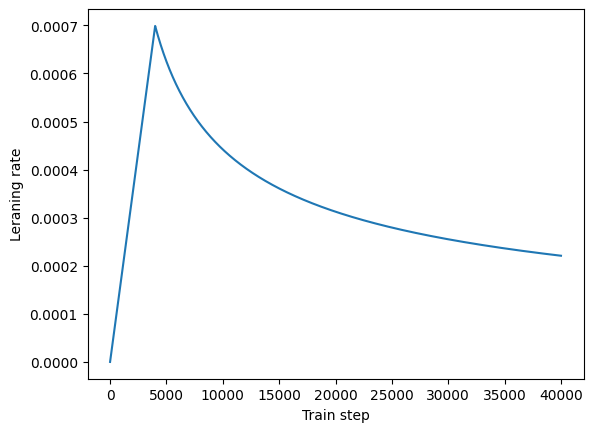

In [34]:
class NoamDecayScheduler:
    def __init__(self, config):
        self.d_model = config["d_model"]
        self.warmup_steps = config["warmup_steps"]
        
    def __call__(self, step):
        step += 1
        arg1 = step ** (-0.5)
        arg2 = step * (self.warmup_steps ** (-1.5))
        
        arg3 = self.d_model ** (-0.5)
        
        return arg3 * np.minimum(arg1, arg2)
    
    
temp_learning_rate_schedule = NoamDecayScheduler({"d_model": 512, "warmup_steps": 4000})
#下面是学习率的设计图
plt.plot(temp_learning_rate_schedule(np.arange(0, 40_000)))
plt.ylabel("Leraning rate")
plt.xlabel("Train step")
plt.show()


### 优化器

In [35]:
from torch.optim.lr_scheduler import LambdaLR
from torch.optim import Adam
    
def get_optimizer(model, config):
    base_lr = 0.1
    beta1 = config["beta1"]
    beta2 = config["beta2"]
    eps = config["eps"]
    optimizer = Adam(model.parameters(), lr=base_lr, betas=(beta1, beta2), eps=eps)
    lr_scheduler = NoamDecayScheduler(config)
    scheduler = LambdaLR(optimizer, lr_lambda=lr_scheduler)
    return optimizer, scheduler

### Callback

In [36]:
from torch.utils.tensorboard import SummaryWriter


class TensorBoardCallback:
    def __init__(self, log_dir, flush_secs=10):
        """
        Args:
            log_dir (str): dir to write log.
            flush_secs (int, optional): write to dsk each flush_secs seconds. Defaults to 10.
        """
        self.writer = SummaryWriter(log_dir=log_dir, flush_secs=flush_secs)

    def draw_model(self, model, input_shape):
        self.writer.add_graph(model, input_to_model=torch.randn(input_shape))
        
    def add_loss_scalars(self, step, loss, val_loss):
        self.writer.add_scalars(
            main_tag="training/loss", 
            tag_scalar_dict={"loss": loss, "val_loss": val_loss},
            global_step=step,
            )
        
    def add_acc_scalars(self, step, acc, val_acc):
        self.writer.add_scalars(
            main_tag="training/accuracy",
            tag_scalar_dict={"accuracy": acc, "val_accuracy": val_acc},
            global_step=step,
        )
        
    def add_lr_scalars(self, step, learning_rate):
        self.writer.add_scalars(
            main_tag="training/learning_rate",
            tag_scalar_dict={"learning_rate": learning_rate},
            global_step=step,
            
        )
    
    def __call__(self, step, **kwargs):
        # add loss
        loss = kwargs.pop("loss", None)
        val_loss = kwargs.pop("val_loss", None)
        if loss is not None and val_loss is not None:
            self.add_loss_scalars(step, loss, val_loss)
        # add acc
        acc = kwargs.pop("acc", None)
        val_acc = kwargs.pop("val_acc", None)
        if acc is not None and val_acc is not None:
            self.add_acc_scalars(step, acc, val_acc)
        # add lr
        learning_rate = kwargs.pop("lr", None)
        if learning_rate is not None:
            self.add_lr_scalars(step, learning_rate)


In [37]:
class SaveCheckpointsCallback:
    def __init__(self, save_dir, save_step=5000, save_best_only=True):
        """
        Save checkpoints each save_epoch epoch. 
        We save checkpoint by epoch in this implementation.
        Usually, training scripts with pytorch evaluating model and save checkpoint by step.

        Args:
            save_dir (str): dir to save checkpoint
            save_epoch (int, optional): the frequency to save checkpoint. Defaults to 1.
            save_best_only (bool, optional): If True, only save the best model or save each model at every epoch.
        """
        self.save_dir = save_dir
        self.save_step = save_step
        self.save_best_only = save_best_only
        self.best_metrics = - np.inf
        
        # mkdir
        if not os.path.exists(self.save_dir):
            os.mkdir(self.save_dir)
        
    def __call__(self, step, state_dict, metric=None):
        if step % self.save_step > 0:
            return
        
        if self.save_best_only:
            assert metric is not None
            if metric >= self.best_metrics:
                # save checkpoints
                torch.save(state_dict, os.path.join(self.save_dir, "best.ckpt"))
                # update best metrics
                self.best_metrics = metric
        else:
            torch.save(state_dict, os.path.join(self.save_dir, f"{step}.ckpt"))



In [38]:
class EarlyStopCallback:
    def __init__(self, patience=5, min_delta=0.01):
        """

        Args:
            patience (int, optional): Number of epochs with no improvement after which training will be stopped.. Defaults to 5.
            min_delta (float, optional): Minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute 
                change of less than min_delta, will count as no improvement. Defaults to 0.01.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.best_metric = - np.inf
        self.counter = 0
        
    def __call__(self, metric):
        if metric >= self.best_metric + self.min_delta:
            # update best metric
            self.best_metric = metric
            # reset counter 
            self.counter = 0
        else: 
            self.counter += 1
            
    @property
    def early_stop(self):
        return self.counter >= self.patience


### training & valuating

In [39]:
@torch.no_grad()
def evaluating(model, dataloader, loss_fct):
    loss_list = []
    for batch in dataloader:
        encoder_inputs = batch["encoder_inputs"]
        encoder_inputs_mask = batch["encoder_inputs_mask"]
        decoder_inputs = batch["decoder_inputs"]
        decoder_labels = batch["decoder_labels"]
        decoder_labels_mask = batch["decoder_labels_mask"]
        
        # 前向计算
        outputs = model(
            encoder_inputs=encoder_inputs, 
            decoder_inputs=decoder_inputs, 
            encoder_inputs_mask=encoder_inputs_mask
            )
        logits = outputs.logits
        loss = loss_fct(logits, decoder_labels)         # 验证集损失
        loss_list.append(loss.cpu().item())
        
    return np.mean(loss_list)


In [40]:
# 训练
def training(
    model, 
    train_loader, 
    val_loader, 
    epoch, 
    loss_fct, 
    optimizer, 
    scheduler=None,
    tensorboard_callback=None,
    save_ckpt_callback=None,
    early_stop_callback=None,
    eval_step=500,
    ):
    record_dict = {
        "train": [],
        "val": []
    }
    
    global_step = 1
    model.train()
    with tqdm(total=epoch * len(train_loader)) as pbar:
        for epoch_id in range(epoch):
            # training
            for batch in train_loader:
                encoder_inputs = batch["encoder_inputs"]
                encoder_inputs_mask = batch["encoder_inputs_mask"]
                decoder_inputs = batch["decoder_inputs"]
                decoder_labels = batch["decoder_labels"]
                
                # 梯度清空
                optimizer.zero_grad()
                
                # 前向计算
                outputs = model(
                    encoder_inputs=encoder_inputs, 
                    decoder_inputs=decoder_inputs, 
                    encoder_inputs_mask=encoder_inputs_mask
                    )
                logits = outputs.logits
                loss = loss_fct(logits, decoder_labels)
                
                # 梯度回传
                loss.backward()
                
                # 调整优化器，包括学习率的变动等
                optimizer.step()
                if scheduler is not None:
                    scheduler.step()
            
                loss = loss.cpu().item()
                # record
                record_dict["train"].append({
                    "loss": loss, "step": global_step
                })
                
                # evaluating
                if global_step % eval_step == 0:
                    model.eval()
                    val_loss = evaluating(model, val_loader, loss_fct)
                    record_dict["val"].append({
                        "loss": val_loss, "step": global_step
                    })
                    model.train()
                    
                    # 1. 使用 tensorboard 可视化
                    cur_lr = optimizer.param_groups[0]["lr"] if scheduler is None else scheduler.get_last_lr()[0]
                    if tensorboard_callback is not None:
                        tensorboard_callback(
                            global_step, 
                            loss=loss, val_loss=val_loss,
                            lr=cur_lr,
                            )
                
                    # 2. 保存模型权重 save model checkpoint
                    if save_ckpt_callback is not None:
                        save_ckpt_callback(global_step, model.state_dict(), metric=-val_loss)

                    # 3. 早停 Early Stop
                    if early_stop_callback is not None:
                        early_stop_callback(-val_loss)
                        if early_stop_callback.early_stop:
                            print(f"Early stop at epoch {epoch_id} / global_step {global_step}")
                            return record_dict
                    
                # udate step
                global_step += 1
                pbar.update(1)
            pbar.set_postfix({"epoch": epoch_id, "loss": loss, "val_loss": val_loss})
        
    return record_dict
        

In [41]:
config = {
    "bos_idx": 1,
    "eos_idx": 3,
    "pad_idx": 0,
    "vocab_size": len(word2idx),
    "max_length": 128,
    "d_model": 512, 
    "dim_feedforward": 2048, 
    "dropout": 0.1, 
    "layer_norm_eps": 1e-6, 
    "num_heads": 8, 
    "num_decoder_layers": 6,
    "num_encoder_layers": 6,
    "label_smoothing": 0.1,
    "beta1": 0.9,
    "beta2": 0.98,
    "eps": 1e-9,
    "warmup_steps": 4_000,
    "share_embedding": True,
    }


def get_dl(dataset, batch_size, shuffle=True):
    sampler = TransformerBatchSampler(dataset, batch_size=batch_size, shuffle_batch=shuffle)
    sample_dl = DataLoader(dataset, batch_sampler=sampler, collate_fn=partial(collate_fct, tokenizer=tokenizer))
    return sample_dl

# dataset
train_ds = LangPairDataset("train", max_length=config["max_length"])
val_ds = LangPairDataset("val", max_length=config["max_length"])
# tokenizer
tokenizer = Tokenizer(word2idx=word2idx, idx2word=idx2word, max_length=config["max_length"])
batch_size = 2048
# dataloader
train_dl = get_dl(train_ds, batch_size=batch_size, shuffle=True)
val_dl = get_dl(val_ds, batch_size=batch_size, shuffle=False)

load train dataset from .cache/de2en_train_128.npy
load val dataset from .cache/de2en_val_128.npy


In [42]:
epoch = 20

# model
model = TransformerModel(config)
# 1. 定义损失函数 采用交叉熵损失
loss_fct = CrossEntropyWithPadding(config)
# 2. 定义优化器 采用 adam
# Optimizers specified in the torch.optim package
optimizer, scheduler = get_optimizer(model, config)

# 1. tensorboard 可视化
if not os.path.exists("runs"):
    os.mkdir("runs")
exp_name = "translate-transformer-{}".format("share" if config["share_embedding"] else "not-share")
tensorboard_callback = TensorBoardCallback(f"runs/{exp_name}")
# tensorboard_callback.draw_model(model, [1, MAX_LENGTH])
# 2. save best
if not os.path.exists("checkpoints"):
    os.makedirs("checkpoints")
save_ckpt_callback = SaveCheckpointsCallback(
    f"checkpoints/{exp_name}", save_step=500, save_best_only=True)
# 3. early stop
early_stop_callback = EarlyStopCallback(patience=8)

model = model.to(device)

record = training(
    model, 
    train_dl, 
    val_dl, 
    epoch, 
    loss_fct, 
    optimizer,
    scheduler,
    tensorboard_callback=tensorboard_callback,
    save_ckpt_callback=save_ckpt_callback,
    early_stop_callback=None,
    eval_step=500
    )

# Training took 3.5 days on 8 P100 GPUs
# We trained the base models for a total of 100,000 steps or 12 hours. For our big models,(described on the bottom line of table 3), step time was 1.0 seconds. The big models were trained for 300,000 steps (3.5 days).

  0%|          | 0/280 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


## 推理

- 翻译项目的评估指标一般是BLEU4，感兴趣的同学自行了解并实现
- 接下来进行翻译推理，并作出注意力的热度图

In [46]:
!ls checkpoints/translate-transformer-share

best.ckpt


In [43]:
# !pip install Cython  # if failed to install fastBPE, try this line
!pip install fastBPE

  Preparing metadata (setup.py) ... done
  Created wheel for fastBPE: filename=fastBPE-0.1.0-cp310-cp310-linux_x86_64.whl size=74025 sha256=403621b79cc2ffc0e7145f52d791521a289b592f70d7cdb4b46b8c8130b59380
  Stored in directory: /root/.cache/pip/wheels/13/5d/b9/4b8897941ebc9e8c6cc3f3ffd3ea5115731754269205098754
Successfully built fastBPE


In [48]:
import torch

state_dict = torch.load(f"checkpoints/{exp_name}/best.ckpt", map_location="cpu")

# checkpoint = torch.load("epoch125-step132426.ckpt", map_location="cpu")
# state_dict = checkpoint["state_dict"]

# update keys by dropping `model`
for key in list(state_dict):
    state_dict[key.replace("model.", "")] = state_dict.pop(key)


In [51]:
# load checkpoints
model = TransformerModel(config)
model.load_state_dict(state_dict)


# from dataset import LangPairDataset
test_ds = LangPairDataset("test", max_length=128, data_dir="../input/wmt16-de-en")
test_dl = DataLoader(test_ds, batch_size=1, collate_fn=partial(collate_fct, tokenizer=tokenizer))

model = model.to(device)
model.eval()
collect = {}
loss_collect = []
for idx, batch in tqdm(enumerate(test_dl)):
    encoder_inputs = batch["encoder_inputs"].to(device=device)
    encoder_inputs_mask = batch["encoder_inputs_mask"].to(device=device)
    decoder_inputs = batch["decoder_inputs"].to(device=device)
    decoder_labels = batch["decoder_labels"].to(device=device)
    
    # 前向计算
    outputs = model(
        encoder_inputs=encoder_inputs, 
        decoder_inputs=decoder_inputs, 
        encoder_inputs_mask=encoder_inputs_mask
        )
    loss = loss_fct(outputs.logits, decoder_labels)         # 验证集损失
    # outputs = model.infer(encoder_inputs=encoder_inputs)
    # print(outputs.logits.shape, decoder_labels.shape)
    
    # loss = loss_fct(outputs.logits[:, :decoder_labels.shape[1]], decoder_labels)         # 验证集损失
    # preds = logits.argmax(dim=-1)
    collect[idx] = {"loss": loss.item(), "src_inputs": encoder_inputs, "trg_inputs": decoder_inputs, "mask": encoder_inputs_mask, "trg_labels": decoder_labels, "preds": outputs.preds}
    loss_collect.append(loss.item())
    
# sort collect by value
collect = sorted(collect.items(), key=lambda x: x[1]["loss"])
print(f"testing loss: {np.array(loss_collect).mean()}")

save cache to .cache/de2en_test_128.npy


0it [00:00, ?it/s]

testing loss: 3.2648377707510283


In [53]:
%pip install sacremoses 

  Obtaining dependency information for sacremoses from https://files.pythonhosted.org/packages/0b/f0/89ee2bc9da434bd78464f288fdb346bc2932f2ee80a90b2a4bbbac262c74/sacremoses-0.1.1-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 40.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


Loading vocabulary from ../input/wmt16-de-en/vocab ...
Read 798250 words (9714 unique) from vocabulary file.
Loading codes from ../input/wmt16-de-en/bpe.10000 ...
Read 10001 codes from the codes file.


  0%|          | 0/128 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


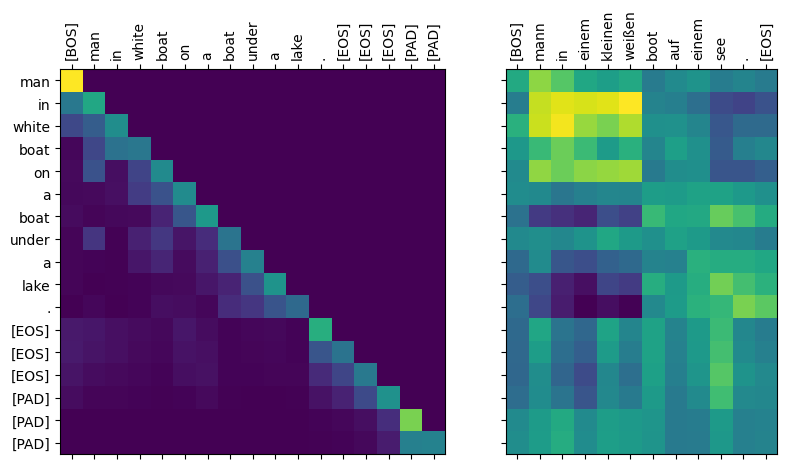

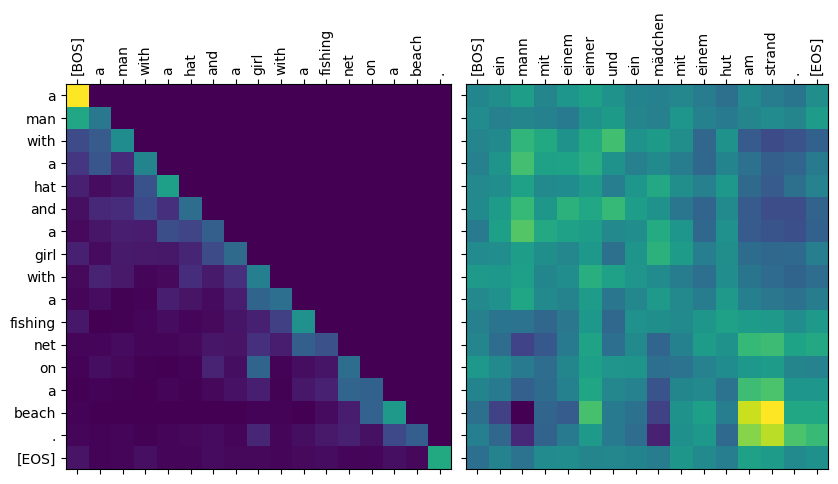

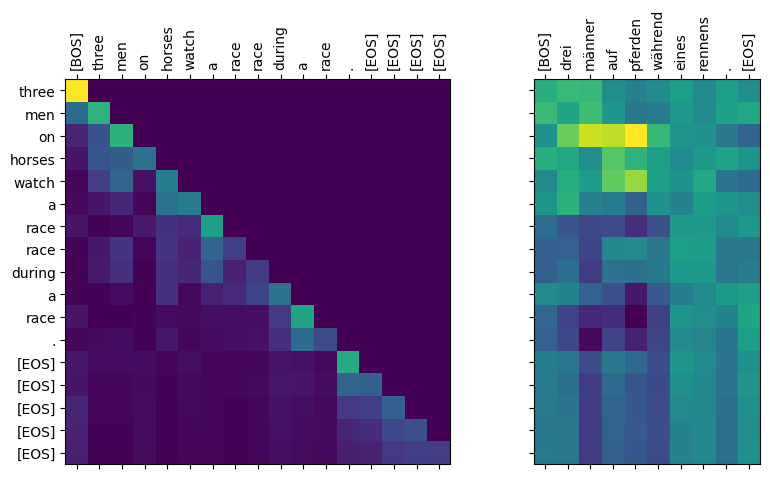

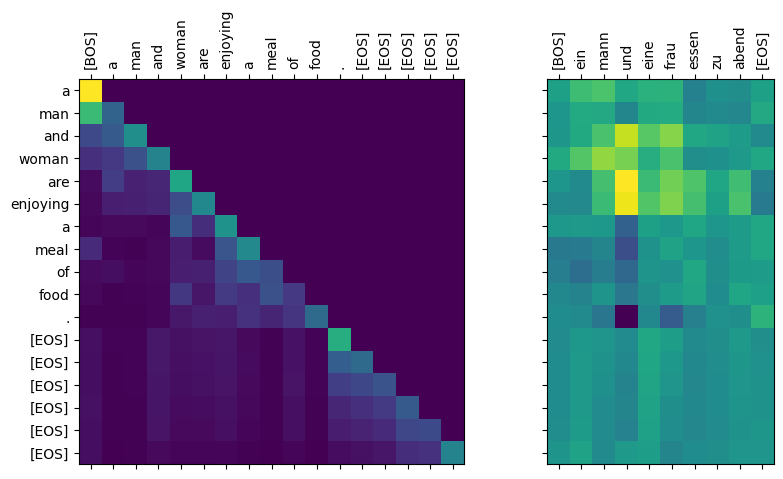

['man in white boat on a boat under a lake.',
 'a man with a hat and a girl with a fishing net on a beach.',
 'three men on horses watch a race race during a race.',
 'a man and woman are enjoying a meal of food.']

In [54]:
import re
from fastBPE import fastBPE
from sacremoses import MosesDetokenizer, MosesTokenizer



class Translator:
    def __init__(self, model, src_tokenizer, trg_tokenizer):
        self.bpe = fastBPE("../input/wmt16-de-en/bpe.10000", "../input/wmt16-de-en/vocab")
        self.mose_tokenizer = MosesTokenizer(lang="de")
        self.mose_detokenizer = MosesDetokenizer(lang="en")
        self.model = model
        self.model.eval()
        self.src_tokenizer = src_tokenizer
        self.trg_tokenizer = trg_tokenizer
        self.pattern = re.compile(r'(@@ )|(@@ ?$)')
        
    def draw_attention_map(self, attn_scores, cross_attn_scores, src_words_list, trg_words_list):
        """绘制注意力热力图
        
        Args:
            - scores (numpy.ndarray): shape = [source sequence length, target sequence length]
        """
        assert len(attn_scores.shape) == 3, "attn_scores shape should be " \
            f"[num heads, target sequence length, target sequence length], but got {attn_scores.shape}"
        attn_scores = attn_scores[:, :len(trg_words_list), :len(trg_words_list)]
        
        assert len(cross_attn_scores.shape) == 3, "attn_scores shape should be " \
            f"[num heads, target sequence length, source sequence length], but got {cross_attn_scores.shape}"
        cross_attn_scores = cross_attn_scores[:, :len(trg_words_list), :len(src_words_list)]
        
        num_heads, trg_len, src_len = cross_attn_scores.shape
        
        fig = plt.figure(figsize=(10, 5), constrained_layout=True)
        grid = plt.GridSpec(trg_len, trg_len + src_len, wspace=0.1, hspace=0.1)
        
        self_map = fig.add_subplot(grid[:,:trg_len])
        self_map.matshow(attn_scores.mean(dim=0), cmap='viridis')
        self_map.set_yticks(range(trg_len), trg_words_list, fontsize=10)
        self_map.set_xticks(range(trg_len), ["[BOS]"] + trg_words_list[:-1], rotation=90)
        
        cross_map = fig.add_subplot(grid[:, trg_len:])
        cross_map.matshow(cross_attn_scores.mean(dim=0), cmap='viridis')
        cross_map.set_yticks(range(trg_len), [], fontsize=6)
        cross_map.set_xticks(range(src_len), src_words_list, rotation=90)
        
        plt.show()
        
    def draw_attention_maps(self, attn_scores, cross_attn_scores, src_words_list, trg_words_list, heads_list):
        """绘制注意力热力图
        
        Args:
            - scores (numpy.ndarray): shape = [source sequence length, target sequence length]
        """
        assert len(attn_scores.shape) == 3, "attn_scores shape should be " \
            f"[num heads, target sequence length, target sequence length], but got {attn_scores.shape}"
        attn_scores = attn_scores[:, :len(trg_words_list), :len(trg_words_list)]
        
        assert len(cross_attn_scores.shape) == 3, "attn_scores shape should be " \
            f"[num heads, target sequence length, source sequence length], but got {cross_attn_scores.shape}"
        cross_attn_scores = cross_attn_scores[:, :len(trg_words_list), :len(src_words_list)]
        # cross_attn_scores = cross_attn_scores[:, :len(src_words_list), :len(src_words_list)]
            
        num_heads, trg_len, src_len = cross_attn_scores.shape
        fig, axes = plt.subplots(2, len(heads_list), figsize=(5 * len(heads_list), 10))
        for i, heads_idx in enumerate(heads_list):
            axes[0, i].matshow(attn_scores[heads_idx], cmap='viridis')
            axes[0, i].set_yticks(range(trg_len), trg_words_list)
            axes[0, i].set_xticks(range(trg_len), ["[BOS]"] + trg_words_list[:-1], rotation=90)
            axes[0, i].set_title(f"head {heads_idx}")
            axes[1, i].matshow(cross_attn_scores[heads_idx], cmap='viridis')
            axes[1, i].set_yticks(range(trg_len), trg_words_list)
            axes[1, i].set_xticks(range(src_len), src_words_list, rotation=90)
            axes[1, i].set_title(f"head {heads_idx}")
            
        plt.show()    
    
        
    def __call__(self, sentence_list, heads_list=None, layer_idx=-1):
        sentence_list = [" ".join(self.mose_tokenizer.tokenize(s.lower())) for s in sentence_list]
        tokens_list = [s.split() for s in self.bpe.apply(sentence_list)]
        
        encoder_input, attn_mask = self.src_tokenizer.encode(
            tokens_list, 
            add_bos=True, 
            add_eos=True, 
            return_mask=True,
            )
        encoder_input = torch.Tensor(encoder_input).to(dtype=torch.int64)

        outputs = model.infer(encoder_inputs=encoder_input, encoder_inputs_mask=attn_mask)
        
        preds = outputs.preds.numpy()
        
        trg_decoded = self.trg_tokenizer.decode(preds, split=True, remove_eos=False, remove_bos=False, remove_pad=False)
        
        src_decoded = self.src_tokenizer.decode(
            encoder_input.numpy(), 
            split=True, 
            remove_bos=False, 
            remove_eos=False
            )
        
        # post processed attn scores
        # outputs.decoder_attentions[-1]  # the last layer of self-attention scores
        
        # draw the attention map of the last decoder block
        for attn_score, cross_attn_score, src, trg in zip(
            outputs.decoder_self_attn_scores[layer_idx], outputs.decoder_cross_attn_scores[layer_idx], src_decoded, trg_decoded):
            if heads_list is None:
                self.draw_attention_map(
                    attn_score,
                    cross_attn_score,
                    src,
                    trg,
                )
            else:
                self.draw_attention_maps(
                    attn_score,
                    cross_attn_score,
                    src,
                    trg,
                    heads_list=heads_list,
                    )
        return [self.mose_detokenizer.tokenize(self.pattern.sub("", s).split()) for s in self.trg_tokenizer.decode(preds)]
        
        
sentence_list = [
    "Mann in einem kleinen weißen Boot auf einem See.",  # Man in a small white boat on a lake.
    "Ein Mann mit einem Eimer und ein Mädchen mit einem Hut am Strand.", # A man with a bucket and a girl in a hat on the beach.
    "Drei Männer auf Pferden während eines Rennens.",  # Three men on horses during a race.
    "Ein Mann und eine Frau essen zu Abend",  # 一个男人和一个女人在吃晚餐
]


# load checkpoints
model = TransformerModel(config)
model.load_state_dict(state_dict)
translator = Translator(model.cpu(), tokenizer, tokenizer)
translator(
    sentence_list,
    layer_idx=-1,
    # heads_list=[0, 1, 2, 3, 4, 5, 6, 7]
    )
    